In [1]:
#get some library
import pandas as pd
import seaborn as sns
from Bio import SeqIO
import numpy as np
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import plotly.plotly as py
from plotly import tools

from ipywidgets import widgets
from IPython.display import display
from plotly.widgets import GraphWidget

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
init_notebook_mode(connected=True)
plt.style.use('ggplot')

<IPython.core.display.Javascript object>

In [2]:
#get only the gene id from
#the new TryTripDB format
def clean_id(temp_id):
    temp_id = temp_id.split(':')[0]
    if temp_id.count('.')>2:
        temp_id = '.'.join(temp_id.split('.')[0:3])
    return temp_id

#helper function to print out
#the protein removed at each threshold
def print_result(start_df_shape, shape_before, df, what):
    removed = shape_before[0]- df.shape[0]
    removed_from_beginning = start_df_shape[0]-df.shape[0]
    if removed > 0:
        print ('removed ',removed, what )  
        print ('tot ', removed_from_beginning, ' entries removed' )
        print ('---------------')
    else:
        print (what)
        print ('nothing removed')
        print ('---------------')

#remove rubbish entires from a
#maxquant output
def clean(df):  
    #remove Only identified by site
    before,start = df.shape,df.shape
    col = 'Only identified by site'
    df = df[df[col] != '+'] 
    print_result(start, before, df, col)
    
    #remove hits from reverse database
    before = df.shape
    col = 'Reverse'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
        
    #remove contaminants (mainly keratine and bsa)
    before = df.shape
    col = 'Potential contaminant'
    df = df[df[col] != '+']
    print_result(start, before, df, col)
    
    ##remove protein groups with less thatn 2 unique peptides
    #before = df.shape
    #col = 'Peptide counts (unique)'
    #df['unique'] = [int(n.split(';')[0]) for n in df[col]]
    #df = df[df['unique'] >= 2]
    #print_result(start, before, df, col)
    return df

In [3]:
#add back the description of the proteins
desc_dict = {}
path = '../TriTrypDB-40_TbruceiTREU927_AnnotatedProteins_VSG.fasta'
with open(path, "r") as handle:
    a=0
    for record in SeqIO.parse(handle, "fasta"):
        a+=1
        temp_id = clean_id(record.id).strip()
        temp_desc = record.description.split('|')[4].strip()#.replace('gene_product=','')
        #print  (record.description.split('|'))
        desc_dict[temp_id]=temp_desc

In [5]:
#read data and log transform for plots
df = pd.read_csv('txt/proteinGroups.txt',sep='\t')
df = clean(df)
df.head()
df=df.dropna(subset=['Protein IDs'],axis=0)

removed  44 Only identified by site
tot  44  entries removed
---------------
removed  29 Reverse
tot  73  entries removed
---------------
removed  27 Potential contaminant
tot  100  entries removed
---------------


In [6]:
df['Gene_id'] = [clean_id(n.split(':')[0].split(';')[0]) for n in df['Protein IDs']]
df['Gene_desc'] = [desc_dict[n].split('=')[1].strip() for n in df['Gene_id']]
df['Gene_id_all'] = [    ';'.join([ clean_id(a) for a in n.split(';')]) for n in df['Protein IDs' ]  ]  
df['Gene_desc_all'] = [    '; '.join([ desc_dict[a].split('=')[1].strip() if a in desc_dict else 'none' for a in n.split(';')]) for n in df['Gene_id_all' ]  ]  


In [7]:
df['MS/MS count 1'] = df['MS/MS count 1']+df['MS/MS count 1'][df['MS/MS count 1']>0].min()
df['MS/MS count 2'] = df['MS/MS count 2']+df['MS/MS count 2'][df['MS/MS count 2']>0].min()

df['Intensity 1'] = df['Intensity 1']+df['Intensity 1'][df['Intensity 1']>0].min()
df['Intensity 2'] = df['Intensity 2']+df['Intensity 2'][df['Intensity 2']>0].min()

df['iBAQ 1'] = df['iBAQ 1']+df['iBAQ 1'][df['iBAQ 1']>0].min()
df['iBAQ 2'] = df['iBAQ 2']+df['iBAQ 2'][df['iBAQ 2']>0].min()

df['LFQ intensity 1'] = df['LFQ intensity 1']+df['LFQ intensity 1'][df['LFQ intensity 1']>0].min()
df['LFQ intensity 2'] = df['LFQ intensity 2']+df['LFQ intensity 2'][df['LFQ intensity 2']>0].min()

df['fc1']= np.log2(df['MS/MS count 1']/df['MS/MS count 2'])
df['fc2']= np.log2(df['Intensity 1']/df['Intensity 2'])
df['fc3']= np.log2(df['iBAQ 1']/df['iBAQ 2'])
df['fc4']= np.log2(df['LFQ intensity 1']/df['LFQ intensity 2'])

df['log10_score'] = np.log10(df['Score'])
df.set_index('Gene_id',inplace=True)
df.head()

,Protein IDs,Majority protein IDs,Peptide counts (all),Peptide counts (razor+unique),Peptide counts (unique),Fasta headers,Number of proteins,Peptides,Razor + unique peptides,Unique peptides,...,Oxidation (M) site IDs,Oxidation (M) site positions,Gene_desc,Gene_id_all,Gene_desc_all,fc1,fc2,fc3,fc4,log10_score
Gene_id,,,,,,,,,,,,,,,,,,,,,
Tb927.5.4460,Tb927.5.4460:mRNA-p1;Tb05.5K5.110:mRNA-p1;Tb11...,Tb927.5.4460:mRNA-p1;Tb05.5K5.110:mRNA-p1;Tb11...,98;98;56,98;98;56,98;98;56,Tb927.5.4460:mRNA-p1 | transcript=Tb927.5.4460...,3,98,98,98,...,70;71;72;73;74;75;76;77;78;79;80;81;82,26;82;251;256;324;350;389;405;481;726;778;797;828,"major vault protein, putative",Tb927.5.4460;Tb05.5K5.110;Tb11.v5.0866,"major vault protein, putative; major vault pro...",0.434889,0.304990,0.305060,0.438368,2.509619
Tb927.5.4470,Tb927.5.4470:mRNA-p1;Tb05.5K5.120:mRNA-p1,Tb927.5.4470:mRNA-p1;Tb05.5K5.120:mRNA-p1,3;3,3;3,3;3,Tb927.5.4470:mRNA-p1 | transcript=Tb927.5.4470...,2,3,3,3,...,NaN,NaN,"hypothetical protein, conserved",Tb927.5.4470;Tb05.5K5.120,"hypothetical protein, conserved; hypothetical ...",-1.000000,-2.062618,-2.174818,-4.005147,0.839220
Tb927.5.4500,Tb927.5.4500:mRNA-p1;Tb05.5K5.150:mRNA-p1,Tb927.5.4500:mRNA-p1;Tb05.5K5.150:mRNA-p1,9;9,9;9,9;9,Tb927.5.4500:mRNA-p1 | transcript=Tb927.5.4500...,2,9,9,9,...,NaN,NaN,"ras-like small GTPase, putative",Tb927.5.4500;Tb05.5K5.150,"ras-like small GTPase, putative; small GTP-bin...",-0.415037,-1.318777,-1.319512,-1.069587,1.865874
Tb927.5.4520,Tb927.5.4520:mRNA-p1;Tb05.5K5.160:mRNA-p1,Tb927.5.4520:mRNA-p1;Tb05.5K5.160:mRNA-p1,114;114,114;114,114;114,Tb927.5.4520:mRNA-p1 | transcript=Tb927.5.4520...,2,114,114,114,...,83;84;85;86;87;88;89;90;91;92;93;94;95;96;97;9...,1;61;236;287;288;293;401;412;463;479;485;645;7...,Kinetochore interacting protein 1,Tb927.5.4520;Tb05.5K5.160,Kinetochore interacting protein 1; hypothetica...,0.260709,0.499484,0.499481,0.474807,2.509619
Tb927.5.4560,Tb927.5.4560:mRNA-p1;Tb11.v5.0409.1-p1;Tb05.5K...,Tb927.5.4560:mRNA-p1;Tb11.v5.0409.1-p1;Tb05.5K...,7;7;7,7;7;7,7;7;7,Tb927.5.4560:mRNA-p1 | transcript=Tb927.5.4560...,3,7,7,7,...,NaN,NaN,"guanine deaminase, putative",Tb927.5.4560;Tb11.v5.0409;Tb05.5K5.200,"guanine deaminase, putative; guanine deaminase...",-0.678072,-1.086925,-1.094146,-0.405151,1.534673


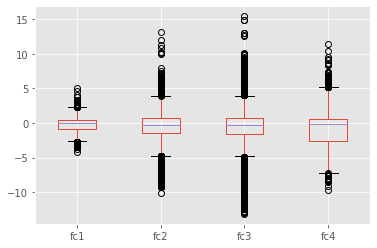

In [8]:
df[['fc1','fc2','fc3','fc4']].plot(kind='box')

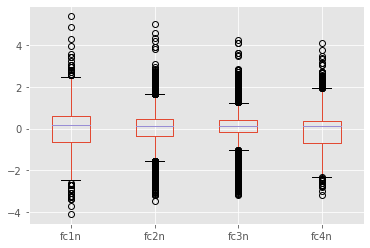

In [9]:
df[['fc1n','fc2n','fc3n','fc4n']] = (df[['fc1','fc2','fc3','fc4']]-df[['fc1','fc2','fc3','fc4']].mean()
                                   )/df[['fc1','fc2','fc3','fc4']].std()
df[['fc1n','fc2n','fc3n','fc4n']].plot(kind='box')   

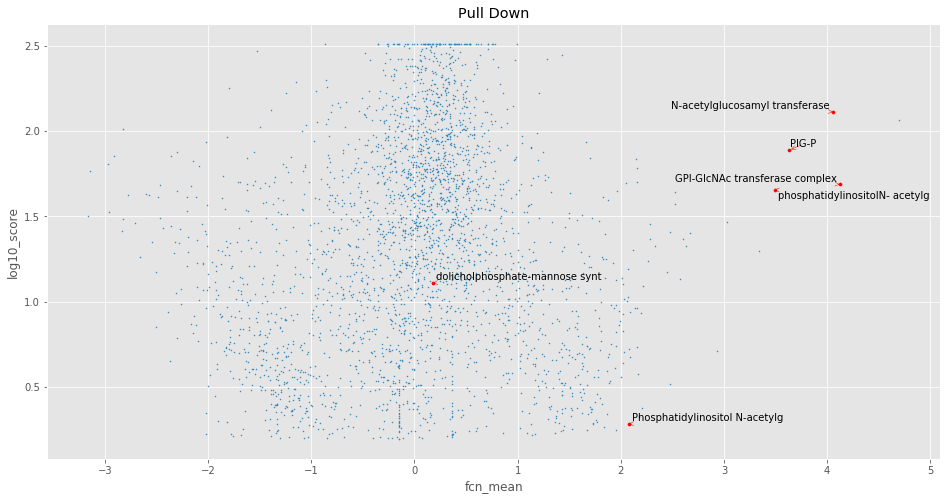

In [24]:
from adjustText import adjust_text
fig,ax = plt.subplots(figsize=(16,8))
df['fcn_mean'] = df[['fc1n','fc2n','fc3n','fc4n']].mean(axis=1,skipna=True)
df.plot(kind='scatter', x='fcn_mean', y='log10_score',ax=ax,s=1)

ids = '''Tb927.10.6140
Tb927.5.3680
Tb927.10.10110
Tb927.3.4570
Tb927.4.780
Tb927.10.4610'''.split('\n')

select = df.loc[ids]
select.plot(kind='scatter', x='fcn_mean', y='log10_score',ax=ax,s=10,c='r')
texts = [plt.text(select.loc[i]['fcn_mean'], 
                  select.loc[i]['log10_score'], 
                  select.loc[i]['Gene_desc'].split(',')[0][0:30],
                  
                 ) for i in select.index.values]



adjust_text(texts, 
            arrowprops=dict(arrowstyle='->',
                            color='red'))
plt.title('Pull Down')
plt.savefig('Fig1')
plt.show()

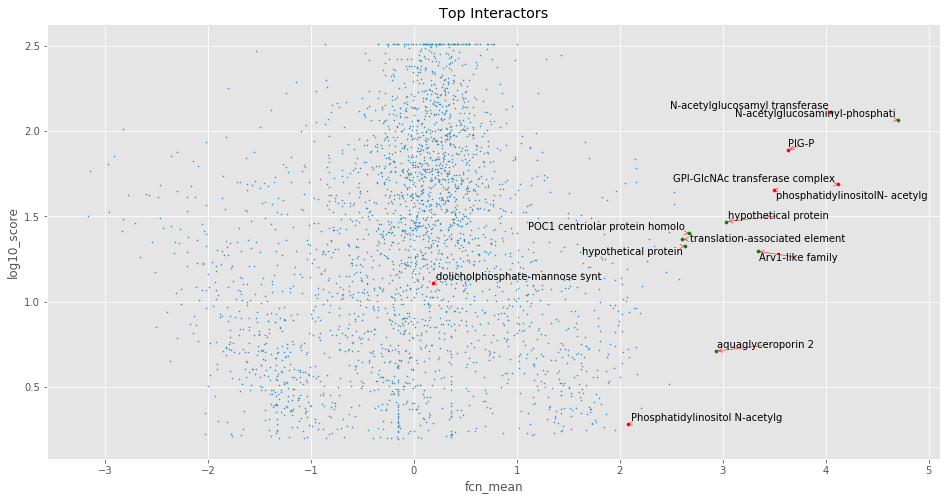

In [25]:
from adjustText import adjust_text
fig,ax = plt.subplots(figsize=(16,8))
df['fcn_mean'] = df[['fc1n','fc2n','fc3n','fc4n']].mean(axis=1,skipna=True)
df.plot(kind='scatter', x='fcn_mean', y='log10_score',ax=ax,s=1)




gd = df.loc[ids]
gd.plot(kind='scatter', x='fcn_mean', y='log10_score', ax=ax, s=10,c='r')
texts = [plt.text(gd.loc[i]['fcn_mean'], 
                  gd.loc[i]['log10_score'], 
                  gd.loc[i]['Gene_desc'].split(',')[0][0:30],
                  
                 ) for i in gd.index.values]
adjust_text(texts, 
            arrowprops=dict(arrowstyle='->',
                            color='red'))





select = df[df['fcn_mean']>2.6]
select = select.drop(gd.index.values,errors ='ignore')
select.plot(kind='scatter', x='fcn_mean', y='log10_score',ax=ax,s=10,c='g')
texts = [plt.text(select.loc[i]['fcn_mean'], 
                  select.loc[i]['log10_score'], 
                  select.loc[i]['Gene_desc'].split(',')[0][0:30],
                  
                 ) for i in select.index.values]


adjust_text(texts, 
            arrowprops=dict(arrowstyle='->',
                            color='red'))




plt.title('Top Interactors')
plt.savefig('Fig2')
plt.show()

In [26]:
cols = ['Protein IDs','fcn_mean','Gene_desc']
df[cols].sort_values('fcn_mean',ascending=False).head(20)

,Protein IDs,fcn_mean,Gene_desc
Gene_id,,,
Tb11.v5.0765,Tb11.v5.0765.1-p1;Tb927.2.1780:mRNA-p1,4.700688,N-acetylglucosaminyl-phosphatidylinositol bios...
Tb927.5.3680,Tb927.5.3680:mRNA-p1,4.121243,"GPI-GlcNAc transferase complex, PIG-H componen..."
Tb927.3.4570,Tb927.3.4570:mRNA-p1,4.054181,"N-acetylglucosamyl transferase component GPI1,..."
Tb927.10.10110,Tb927.10.10110:mRNA-p1,3.633640,"PIG-P, putative"
Tb927.10.6140,Tb927.10.6140:mRNA-p1;Tb11.v5.0206.1-p1,3.493233,phosphatidylinositolN- acetylglucosaminyltrans...
Tb927.3.2480,Tb927.3.2480:mRNA-p1,3.338682,"Arv1-like family, putative"
Tb927.9.14280,Tb927.9.14280:mRNA-p1,3.034430,"hypothetical protein, conserved"
Tb927.10.14170,Tb927.10.14170:mRNA-p1,2.933314,aquaglyceroporin 2
Tb927.10.2860,Tb927.10.2860:mRNA-p1,2.668967,POC1 centriolar protein homolog


In [27]:
df.to_csv('rank_protein.csv')

In [31]:
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
#interactive plot 'logFC',y='log10p'

the_rest = df[df['fcn_mean']<2]
up_control = df[df['fcn_mean']>2]

#select.loc[i]['fcn_mean'], 
#                  select.loc[i]['log10_score'], 
#                  select.loc[i]['Gene_desc'].split(',')[0][0:30],



trace_1 = go.Scatter(
    x=the_rest.fcn_mean,
    y=the_rest['log10_score'],
    mode='markers',
    name='MA Plot',
    #text = [a + ' ' +b for a,b in zip(temp.index.values, temp.Gene_desc)],
    #hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'blue'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)

trace_2 = go.Scatter(
    x=up_control.fcn_mean,
    y=up_control['log10_score'],
    mode='markers',
    name='MA Plot',
    text = up_control.Gene_desc,# +' '+up_control.desc,
    hoverinfo = 'text',
    marker=dict(
        #size=16,
        color = 'green'#np.log10(temp.Score), #set color equal to a variable
        #colorscale='Bluered',
        #showscale=True
    )
)




layout = dict(title='Vulcano',
             width=1000,
             height=800)


fig = go.Figure(data=[trace_1,trace_2], 
                layout=layout)
iplot(fig, filename='test')